# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [18]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

If you are having trouble with the in-browser display — e.g., if it is running slowly on your laptop — then you can try the pybullet display instead (`display=False` and `display_pybullet=True`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

In [19]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=True,
    seed=None,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`

In [20]:
simulator.camera_sideview()

Find the location of each star (you will need this information to derive your sensor model):

In [21]:
for (i, star) in enumerate(simulator.stars):
    print(f'star {i} : alpha = {star["alpha"]:5.2f} : delta = {star["delta"]:5.2f}')

star 0 : alpha = -0.10 : delta = -0.15
star 1 : alpha =  0.00 : delta = -0.15
star 2 : alpha =  0.10 : delta = -0.15
star 3 : alpha =  0.00 : delta =  0.00
star 4 : alpha = -0.10 : delta =  0.15
star 5 : alpha =  0.00 : delta =  0.15
star 6 : alpha =  0.10 : delta =  0.15


In [22]:
alphas = [-.1, 0, 0.1, 0, -0.1, 0, 0.1]
deltas = [-0.15, -0.15, -0.15, 0, .15, .15, .15]
alphas, deltas

([-0.1, 0, 0.1, 0, -0.1, 0, 0.1], [-0.15, -0.15, -0.15, 0, 0.15, 0.15, 0.15])

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

## var checking

In [23]:
A = np.array([[ 0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  1., -0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -0., -0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])
        
B = np.array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-3.74659401e-02,  7.49318801e-02, -3.74659401e-02,
          1.37647631e-17],
        [-6.48929117e-02, -9.17650871e-18,  6.48929117e-02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          6.22171946e-02]])
        
C = np.array([[-2.651426  ,  0.04000563, -0.3987219 ,  0.        ,  0.        ,
          0.        ],
        [-0.04000563,  2.68556349,  0.26337851,  0.        ,  0.        ,
          0.        ],
        [-2.625     ,  0.        , -0.39672995,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  2.68495987,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-2.651426  , -0.04000563, -0.3987219 ,  0.        ,  0.        ,
          0.        ],
        [ 0.04000563,  2.68556349, -0.26337851,  0.        ,  0.        ,
          0.        ],
        [-2.625     ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  2.625     ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-2.651426  , -0.04000563,  0.3987219 ,  0.        ,  0.        ,
          0.        ],
        [ 0.04000563,  2.68556349,  0.26337851,  0.        ,  0.        ,
          0.        ],
        [-2.625     ,  0.        ,  0.39672995,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  2.68495987,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-2.651426  ,  0.04000563,  0.3987219 ,  0.        ,  0.        ,
          0.        ],
        [-0.04000563,  2.68556349, -0.26337851,  0.        ,  0.        ,
          0.        ]])
        
K = np.array([[ 7.82718250e-16, -7.07106781e-01, -4.08248290e-01,
         -1.94906114e+00, -3.37587293e+00,  2.65757997e-15],
        [-7.68735572e-16,  9.70141776e-16,  8.16496581e-01,
          3.89812228e+00,  7.43027507e-16, -3.21738452e-15],
        [-1.39826783e-17,  7.07106781e-01, -4.08248290e-01,
         -1.94906114e+00,  3.37587293e+00,  5.59804552e-16],
        [ 1.00000000e+00, -1.00273328e-16, -2.59770982e-16,
         -1.95537478e-15, -1.00563912e-15,  5.75720892e+00]])
        
L = np.array([[-4.30474997e-01, -6.49515535e-03, -4.26184577e-01,
          1.11728553e-17, -4.30474997e-01,  6.49515535e-03,
         -4.26184577e-01,  1.09233458e-17, -4.30474997e-01,
          6.49515535e-03, -4.26184577e-01,  1.11728553e-17,
         -4.30474997e-01, -6.49515535e-03],
        [ 6.39636391e-03,  4.29385591e-01,  3.82730943e-18,
          4.29289080e-01, -6.39636391e-03,  4.29385591e-01,
         -1.09233458e-17,  4.19702301e-01, -6.39636391e-03,
          4.29385591e-01, -2.56740011e-17,  4.29289080e-01,
          6.39636391e-03,  4.29385591e-01],
        [-6.02532678e-01,  3.98007140e-01, -5.99522524e-01,
         -9.98284038e-17, -6.02532678e-01, -3.98007140e-01,
         -4.84872561e-16, -9.75990603e-17,  6.02532678e-01,
          3.98007140e-01,  5.99522524e-01, -9.98284038e-17,
          6.02532678e-01, -3.98007140e-01],
        [-3.59781870e-01,  2.37656410e-01, -3.57984459e-01,
         -1.91867698e-16, -3.59781870e-01, -2.37656410e-01,
         -4.50681758e-16, -1.87582955e-16,  3.59781870e-01,
          2.37656410e-01,  3.57984459e-01, -1.91867698e-16,
          3.59781870e-01, -2.37656410e-01],
        [ 5.64839191e-03,  3.79174501e-01,  6.30051196e-17,
          3.79089276e-01, -5.64839191e-03,  3.79174501e-01,
          4.19355833e-17,  3.70623547e-01, -5.64839191e-03,
          3.79174501e-01,  2.08660471e-17,  3.79089276e-01,
          5.64839191e-03,  3.79174501e-01],
        [-3.79556298e-01, -5.72687645e-03, -3.75773370e-01,
         -9.09985601e-17, -3.79556298e-01,  5.72687645e-03,
         -3.75773370e-01, -8.89664025e-17, -3.79556298e-01,
          5.72687645e-03, -3.75773370e-01, -9.09985601e-17,
         -3.79556298e-01, -5.72687645e-03]])

In [24]:
A.shape, B.shape, C.shape, K.shape, L.shape

((6, 6), (6, 4), (14, 6), (4, 6), (6, 14))

In [25]:
class Controller:
    def __init__(self):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        self.variables_to_log = []
        
        self.A = np.array([[ 0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1., -0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])
        
        self.B = np.array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.80949551e-34, -3.74659401e-02,  7.49318801e-02,
        -3.74659401e-02],
       [-4.58825436e-18, -6.48929117e-02,  0.00000000e+00,
         6.48929117e-02],
       [-6.22171946e-02,  0.00000000e+00, -7.61940882e-18,
         0.00000000e+00]])
        
        self.C = np.array([[-2.651426  ,  0.04000563, -0.3987219 ,  0.        ,  0.        ,
         0.        ],
       [-0.04000563,  2.68556349,  0.26337851,  0.        ,  0.        ,
         0.        ],
       [-2.625     ,  0.        , -0.39672995,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.68495987,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-2.651426  , -0.04000563, -0.3987219 ,  0.        ,  0.        ,
         0.        ],
       [ 0.04000563,  2.68556349, -0.26337851,  0.        ,  0.        ,
         0.        ],
       [-2.625     ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.625     ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-2.651426  , -0.04000563,  0.3987219 ,  0.        ,  0.        ,
         0.        ],
       [ 0.04000563,  2.68556349,  0.26337851,  0.        ,  0.        ,
         0.        ],
       [-2.625     ,  0.        ,  0.39672995,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.68495987,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-2.651426  ,  0.04000563,  0.3987219 ,  0.        ,  0.        ,
         0.        ],
       [-0.04000563,  2.68556349, -0.26337851,  0.        ,  0.        ,
         0.        ]])
        
        self.K = np.array([[-3.16227766e+01,  9.43936584e-15, -1.12813549e-15,
        -3.62320459e-15,  2.38750234e-15, -3.34144958e+01],
       [ 1.50563102e-15, -2.23606798e+01, -1.29099445e+00,
        -3.62665206e+00, -1.98639914e+01,  1.77324385e-15],
       [ 4.28505300e-15, -3.26568343e-16,  2.58198890e+00,
         7.25330412e+00,  5.59843515e-16,  2.71545960e-16],
       [-9.66335724e-15,  2.23606798e+01, -1.29099445e+00,
        -3.62665206e+00,  1.98639914e+01, -6.13688534e-15]])
        
        self.L = np.array([[-4.30474997e-01, -6.49515535e-03, -4.26184577e-01,
         1.11728553e-17, -4.30474997e-01,  6.49515535e-03,
        -4.26184577e-01,  1.09233458e-17, -4.30474997e-01,
         6.49515535e-03, -4.26184577e-01,  1.11728553e-17,
        -4.30474997e-01, -6.49515535e-03],
       [ 6.39636391e-03,  4.29385591e-01,  3.82730943e-18,
         4.29289080e-01, -6.39636391e-03,  4.29385591e-01,
        -1.09233458e-17,  4.19702301e-01, -6.39636391e-03,
         4.29385591e-01, -2.56740011e-17,  4.29289080e-01,
         6.39636391e-03,  4.29385591e-01],
       [-6.02532678e-01,  3.98007140e-01, -5.99522524e-01,
        -9.98284038e-17, -6.02532678e-01, -3.98007140e-01,
        -4.84872561e-16, -9.75990603e-17,  6.02532678e-01,
         3.98007140e-01,  5.99522524e-01, -9.98284038e-17,
         6.02532678e-01, -3.98007140e-01],
       [-3.59781870e-01,  2.37656410e-01, -3.57984459e-01,
        -1.91867698e-16, -3.59781870e-01, -2.37656410e-01,
        -4.50681758e-16, -1.87582955e-16,  3.59781870e-01,
         2.37656410e-01,  3.57984459e-01, -1.91867698e-16,
         3.59781870e-01, -2.37656410e-01],
       [ 5.64839191e-03,  3.79174501e-01,  6.30051196e-17,
         3.79089276e-01, -5.64839191e-03,  3.79174501e-01,
         4.19355833e-17,  3.70623547e-01, -5.64839191e-03,
         3.79174501e-01,  2.08660471e-17,  3.79089276e-01,
         5.64839191e-03,  3.79174501e-01],
       [-3.79556298e-01, -5.72687645e-03, -3.75773370e-01,
        -9.09985601e-17, -3.79556298e-01,  5.72687645e-03,
        -3.75773370e-01, -8.89664025e-17, -3.79556298e-01,
         5.72687645e-03, -3.75773370e-01, -9.09985601e-17,
        -3.79556298e-01, -5.72687645e-03]])
        
        self.dt = 0.04
    
    def reset(self):
        self.xhat = np.array([[0.],[0.],[0.],[0.],[0.],[0.]])
    
    def run(self, t, star_meas):
        """
        star_meas is a 1d array of length 14 - the image coordinates
        y_i and z_i of the i'th star (for i = 0, ..., 6) are at index
        2*i and 2*i+1 of this array, respectively
        """

        
        u = -self.K @ self.xhat
        
        y = np.array([[star_meas[0]],[star_meas[1]],[star_meas[2]],[star_meas[3]],[star_meas[4]],[star_meas[5]],[star_meas[6]],[star_meas[7]],[star_meas[8]],[star_meas[9]],[star_meas[10]],[star_meas[11]],[star_meas[12]],[star_meas[13]]])
        
        self.xhat += (self.dt * self.A @ self.xhat + self.B @ u - self.L@(self.C@self.xhat-y))
        
        # FIXME: replace the following lines
        
        
        greatest = abs(max(u[0][0], u[1][0], u[2][0], u[3][0]))
        
        
        if (greatest == 0):
            torque_1 = u[0][0]
            torque_2 = u[1][0]
            torque_3 = u[2][0]
            torque_4 = u[3][0]
        else:
            torque_1 = u[0][0] / greatest
            torque_2 = u[1][0] / greatest
            torque_3 = u[2][0] / greatest
            torque_4 = u[3][0] / greatest        
        
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [26]:
controller = Controller()

In [27]:
simulator.camera_scopeview()

You could reset the simulator with given initial conditions, optionally specifying scope noise (default is `0.1`), i.e., the standard deviation of the $y$ and $z$ components of each star tracker measurement.

In [28]:
simulator.reset(
    orientation={
        'yaw': 0.0,
        'pitch': 0.,
        'roll': 0.0,
    },
    angular_velocity={
        'x': 0.,
        'y': 0.,
        'z': 0.,
    },
    scope_noise=0.1,
)

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.1$).

In [199]:
simulator.reset(
    orientation=None,
    angular_velocity=None,
    scope_noise=0.1,
)

In [29]:
simulator.camera_sideview()

Reset the controller.

In [30]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [31]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

Get, show, and save a snapshot of the simulation after the last time step.

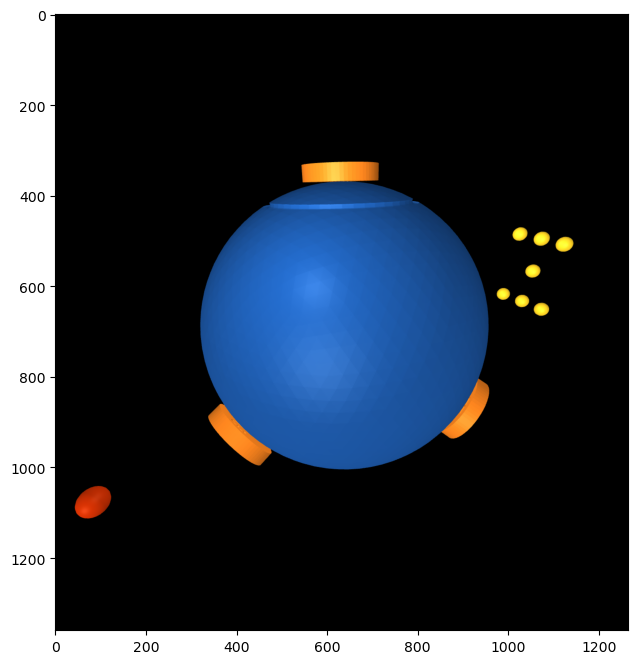

In [15]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

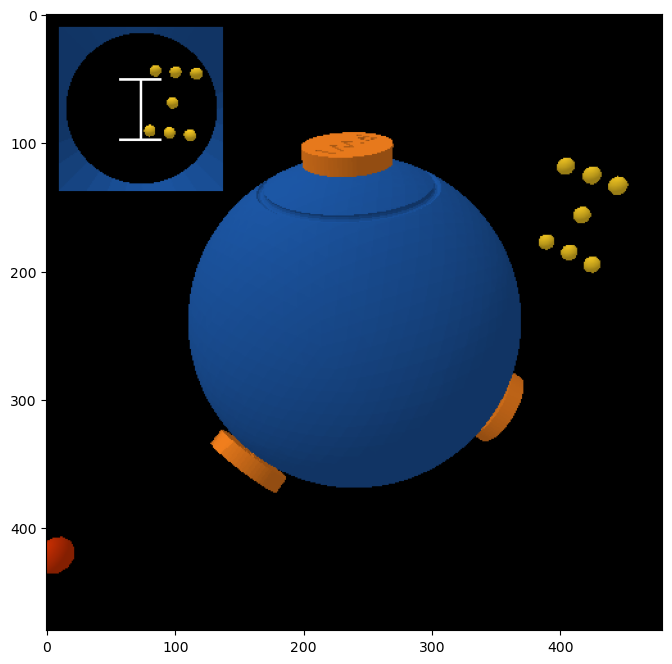

In [16]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

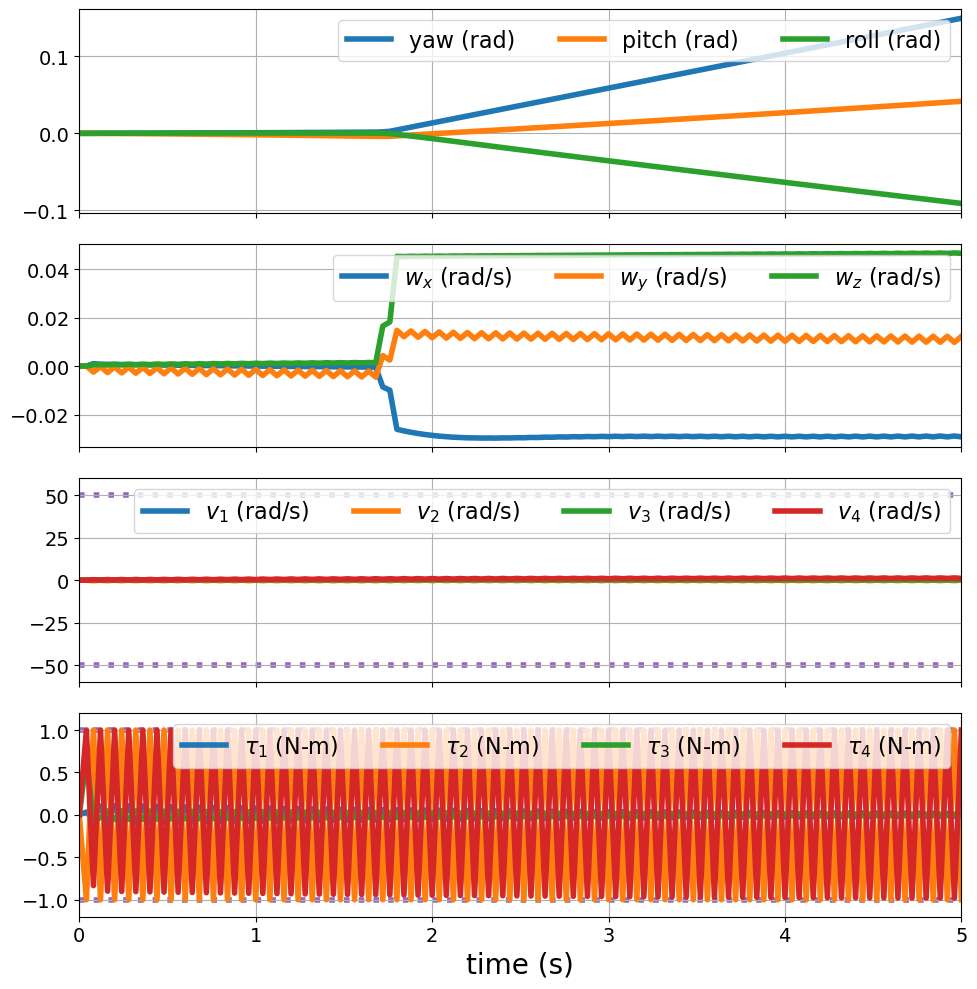

In [17]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=4)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=4)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(-y, z, label=f'star {i}', linewidth=0.5, marker='.', markersize=10)
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)